In [1]:
import numpy
import analysis
import lsst.daf.persistence

In [2]:
butler = lsst.daf.persistence.Butler("/lustre/Subaru/SSP/rerun/yasuda/SSP3.8.5_20150725/")

In [3]:
objIds = [37480444425426832,37480727893263379,37480440130461503,37480444425423299,
          37480581864381920,37485117349844128]
splits = analysis.splitCoaddId(objIds, hasFilter=False)
dataIDs = [dict(tract=int(d[0]), patch=str(d[1]))
           for d in set((splits["tract"][i], splits["patch"][i]) for i in range(len(objIds)))]

In [4]:
loader = analysis.CatalogLoader(butler, filters="griz")

In [26]:
catalog = loader.read(dataIDs[:1], progress=True)

In [6]:
#r = [catalog.find(i) for i in objIds]

In [7]:
def recordStats(record, filters="griz"):
    meas = lambda b, suffix: record.get("meas.{0}.{1}".format(b, suffix))
    forced = lambda b, suffix: record.get("forced.{0}.{1}".format(b, suffix))
    detR = lambda b, suffix: meas(b, suffix).getDeterminantRadius()
    trR = lambda b, suffix: meas(b, suffix).getTraceRadius()
    lines = [
        " | ".join("{0:>21s}".format(b) if not record.get("merge.measurement.{0}".format(b))
                   else "{0:>20s}*".format(b)
                   for b in filters),
        " | ".join("{0:>10s} {1:>10s}".format("meas", "forced") for b in filters),
        "-+-".join("-"*21 for b in filters),
        " | ".join("{0:5.2f}±{1:4.2f} {2:5.2f}±{3:4.2f}".format(
                      meas(b, "cmodel.mag"), meas(b, "cmodel.mag.err"),
                      forced(b, "cmodel.mag"), forced(b, "cmodel.mag.err")
                   )
                  for b in filters) + "  CModel mag",
        " | ".join("{0:5.2f}±{1:4.2f} {2:5.2f}±{3:4.2f}".format(
                      meas(b, "mag.kron"), meas(b, "mag.kron.err"),
                      forced(b, "mag.kron"), forced(b, "mag.kron.err")
                   )
                  for b in filters) + " Kron mag",
        " | ".join("{0:10.2f} {1:10.2f}".format(meas(b, "cmodel.flux")/meas(b, "cmodel.flux.err"),
                                                forced(b, "cmodel.flux")/forced(b, "cmodel.flux.err"))
                  for b in filters) + " CModel SNR",
        " | ".join("{0:10.2f} {1:10.2f}".format(meas(b, "flux.kron")/meas(b, "flux.kron.err"),
                                                forced(b, "flux.kron")/forced(b, "flux.kron.err"))
                  for b in filters) + " Kron SNR",
        " | ".join("{0:10.2f} {1:10.2f}".format(meas(b, "cmodel.fracDev"), forced(b, "cmodel.fracDev"))
                  for b in filters) + " CModel fracDev",
        " | ".join(" tr={0:6.2f}  det={1:5.2f}".format(trR(b, "cmodel.initial.ellipse"), detR(b, "cmodel.initial.ellipse"))
                  for b in filters) + " CModel initial radius",
        " | ".join(" tr={0:6.2f}  det={1:5.2f}".format(trR(b, "cmodel.exp.ellipse"), detR(b, "cmodel.exp.ellipse"))
                  for b in filters) + " CModel exp radius",
        " | ".join(" tr={0:6.2f}  det={1:5.2f}".format(trR(b, "cmodel.dev.ellipse"), detR(b, "cmodel.dev.ellipse"))
                  for b in filters) + " CModel dev radius",
        " | ".join(" tr={0:6.2f}  det={1:5.2f}".format(trR(b, "shape.sdss"), detR(b, "shape.sdss"))
                  for b in filters) + " SDSS shape radius",
        " | ".join(" tr={0:6.2f}  det={1:5.2f}".format(trR(b, "shape.hsm.moments"), detR(b, "shape.hsm.moments"))
                  for b in filters) + " HSM shape radius",
        " | ".join("{0:10.2f} {1:10.2f}".format(meas(b, "flux.kron.radius"), forced(b, "flux.kron.radius"))
                  for b in filters) + " Kron radius (det)",
    ]
    print "\n".join(lines)
#recordStats(r[0])

                    g |                     r |                    i* |                     z
      meas     forced |       meas     forced |       meas     forced |       meas     forced
----------------------+-----------------------+-----------------------+----------------------
  nan± nan 25.72±0.02 | 25.60±0.03 25.57±0.03 | 24.29±0.02 24.29±0.02 | 22.07±0.03 24.31±0.04  CModel mag
25.61±0.38 26.10±0.43 | 25.06±0.26 25.48±0.43 | 24.45±0.17 24.45±0.17 | 24.95±0.42 24.32±0.33 Kron mag
       nan      55.89 |      35.92      35.69 |      60.59      60.59 |      35.81      27.09 CModel SNR
      2.85       2.54 |       4.24       2.52 |       6.39       6.39 |       2.58       3.34 Kron SNR
       nan       1.00 |       0.34       0.00 |       1.00       1.00 |       1.00       1.00 CModel fracDev
 tr=   nan  det=  nan |  tr=  1.23  det= 0.98 |  tr=  2.15  det= 2.14 |  tr=  4.23  det= 3.65 CModel initial radius
 tr=   nan  det=  nan |  tr=  1.75  det= 0.90 |  tr=  2.37  det= 2.34 |  tr=

In [8]:
import matplotlib
%matplotlib inline

In [27]:
flags = ["i.flags.pixel.edge",
         "i.flags.pixel.saturated.center",
         "i.flags.pixel.cr.center",
         "i.flags.pixel.bad",
         "meas.i.cmodel.flux.flags",
         "meas.i.centroid.sdss.flags",]
mask = numpy.logical_and(
    catalog.get("detect.is-primary"),
    numpy.logical_not(numpy.logical_or.reduce([catalog.get(s) for s in flags]))
    )

In [47]:
def col(field):
    return catalog.get("meas.i.%s" % field)[mask]
def snr(flux):
    return col(flux)/col(flux+".err")

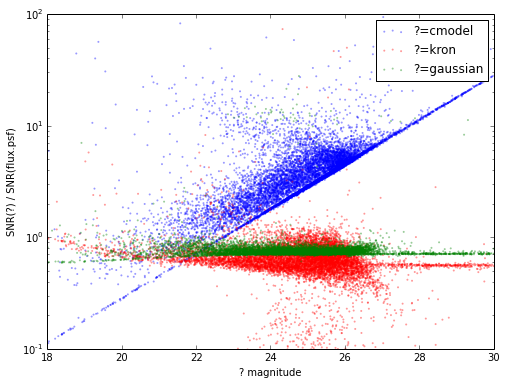

In [58]:
fig = matplotlib.pyplot.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)
scatterKwds = dict(s=4, linewidth=0, alpha=0.4)
ax.scatter(col("cmodel.mag"),
           snr("cmodel.flux")/snr("flux.psf"),
           c='blue', label="?=cmodel",
           **scatterKwds)
ax.scatter(col("mag.kron"),
           snr("flux.kron")/snr("flux.psf"),
           c='red', label="?=kron",
            **scatterKwds)
ax.scatter(col("mag.gaussian"),
           snr("flux.gaussian")/snr("flux.psf"),
           c='green', label="?=gaussian",
            **scatterKwds)
ax.semilogy()
ax.legend()
ax.set_xlabel("? magnitude")
ax.set_ylabel("SNR(?) / SNR(flux.psf)")
ax.set_xlim(18.0, 30.0)
ax.set_ylim(0.1, 100.0)
fig.savefig("SNRvsMag.png")

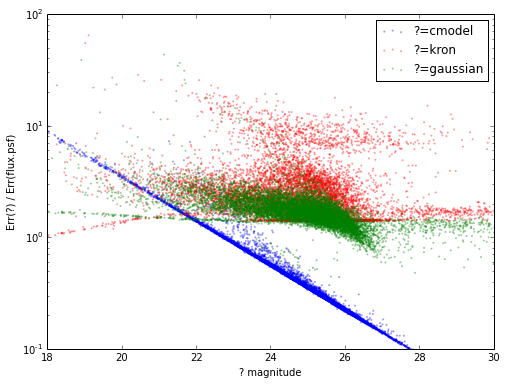

In [60]:
fig = matplotlib.pyplot.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)
scatterKwds = dict(s=4, linewidth=0, alpha=0.4)
ax.scatter(col("cmodel.mag"),
           col("cmodel.flux.err")/col("flux.psf.err"),
           c='blue', label="?=cmodel",
           **scatterKwds)
ax.scatter(col("mag.kron"),
           col("flux.kron.err")/col("flux.psf.err"),
           c='red', label="?=kron",
            **scatterKwds)
ax.scatter(col("mag.gaussian"),
           col("flux.gaussian.err")/col("flux.psf.err"),
           c='green', label="?=gaussian",
            **scatterKwds)
ax.semilogy()
ax.legend()
ax.set_xlabel("? magnitude")
ax.set_ylabel("Err(?) / Err(flux.psf)")
ax.set_xlim(18.0, 30.0)
ax.set_ylim(0.1, 100.0)
fig.savefig("ErrvsMag.png")